In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [29]:
data_B1 = pd.read_csv('data_weather&holidays.csv', index_col=0)
data_B1

,Datetime,Valeur,working day,Radiation (Wh/m²),Temperatures (°C),Wind speed (m/s)
0,2014-01-06 02:00:00,6.51,True,0.000000,9.508508,3.071947
1,2014-01-06 02:15:00,6.51,True,0.000000,9.508508,3.071947
2,2014-01-06 02:30:00,6.72,True,0.000000,9.508508,3.071947
3,2014-01-06 02:45:00,6.51,True,0.000000,9.508508,3.071947
4,2014-01-06 03:00:00,6.93,True,0.000000,9.902185,2.997679
...,...,...,...,...,...,...
209821,2020-06-30 23:00:00,5.04,True,0.000000,18.468164,1.596285
209822,2020-06-30 23:15:00,3.36,True,0.000000,18.468164,1.596285
209823,2020-06-30 23:30:00,3.36,True,0.000000,18.468164,1.596285
209824,2020-06-30 23:45:00,4.20,True,0.000000,18.468164,1.596285


In [34]:
# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            'callbacks': [earlyStop]
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [35]:
deep_learner = DeepModelTS(
data = data_B1,
Y_var = 'Valeur',
lag = 34,
LSTM_layer_depth = 50,
epochs = 50,
batch_size = 200,
train_test_split = 0.15
)

In [36]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/50
892/892 [==============================] - 55s 61ms/step - loss: 14.5680 - val_loss: 2.1221
Epoch 2/50
892/892 [==============================] - 59s 66ms/step - loss: 2.4293 - val_loss: 1.3843
Epoch 3/50
892/892 [==============================] - 58s 65ms/step - loss: 1.9865 - val_loss: 1.3080
Epoch 4/50
892/892 [==============================] - 59s 66ms/step - loss: 1.8937 - val_loss: 1.2880
Epoch 5/50
892/892 [==============================] - 51s 57ms/step - loss: 1.8191 - val_loss: 1.2744
Epoch 6/50
892/892 [==============================] - 54s 61ms/step - loss: 1.7831 - val_loss: 1.2394
Epoch 7/50
892/892 [==============================] - 55s 62ms/step - loss: 1.7634 - val_loss: 1.2216
Epoch 8/50
892/892 [==============================] - 53s 60ms/step - loss: 1.7375 - val_loss: 1.2082
Epoch 9/50
892/892 [==============================] - 55s 62ms/step - loss: 1.7194 - val_loss: 1.2023
Epoch 10/50
892/892 [==============================] - 55s 62ms/step - loss: 1.70

In [23]:
from tensorflow.keras.models import load_model
model = load_model('./LSTM_25ep.h5')

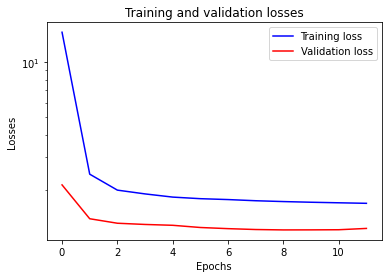

In [37]:
def plot_train_history(model):
    '''
    Convergence plots to have an idea on how the training performs
    '''
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']

    plt.figure()
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
    plt.yscale("log")
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and validation losses')
    plt.legend()
    plt.show()  
plot_train_history(model)

In [22]:
from tensorflow.keras.models import load_model
model.save('LSTM_25ep.h5')  # creates a HDF5 file 'my_model.h5'
del model

In [8]:
# Fitting the model
model2 = deep_learner.LSTModel()

Epoch 1/10
892/892 [==============================] - 54s 60ms/step - loss: 4.9094 - val_loss: 1.3432
Epoch 2/10
892/892 [==============================] - 50s 56ms/step - loss: 1.8093 - val_loss: 1.2562
Epoch 3/10
892/892 [==============================] - 52s 58ms/step - loss: 1.7745 - val_loss: 1.2465
Epoch 4/10
892/892 [==============================] - 53s 60ms/step - loss: 1.7509 - val_loss: 1.2522
Epoch 5/10
892/892 [==============================] - 51s 57ms/step - loss: 1.7160 - val_loss: 1.2303
Epoch 6/10
892/892 [==============================] - 53s 60ms/step - loss: 1.6903 - val_loss: 1.1939
Epoch 7/10
892/892 [==============================] - 51s 57ms/step - loss: 1.6681 - val_loss: 1.1863
Epoch 8/10
892/892 [==============================] - 52s 58ms/step - loss: 1.6517 - val_loss: 1.1612
Epoch 9/10
892/892 [==============================] - 57s 64ms/step - loss: 1.6290 - val_loss: 1.1627
Epoch 10/10
892/892 [==============================] - 50s 56ms/step - loss: 1.611

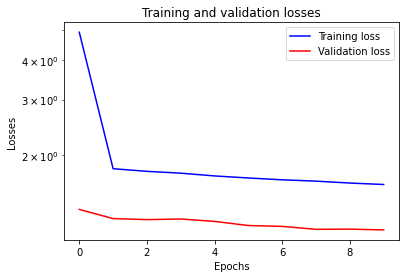

In [12]:
def plot_train_history(model):
    '''
    Convergence plots to have an idea on how the training performs
    '''
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']

    plt.figure()
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
    plt.yscale("log")
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and validation losses')
    plt.legend()
    plt.show()  
plot_train_history(model2)

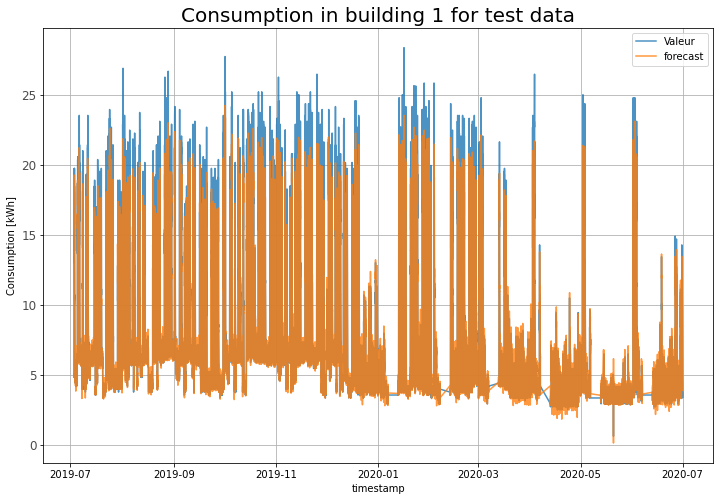

In [38]:
yhat = deep_learner.predict()# Constructing the forecast dataframe
fc = data_B1.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
fc.sort_values('Datetime', inplace=True)
fc['Datetime'] = pd.to_datetime(fc['Datetime'])
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc,label=dtype,alpha=0.8)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()

In [39]:
fc = fc.set_index('Datetime')
fc.index = pd.to_datetime(fc.index)
fc['Datetime'] = fc.index
fc.head()

,index,Valeur,working day,Radiation (Wh/m²),Temperatures (°C),Wind speed (m/s),forecast,Datetime
Datetime,,,,,,,,
2019-07-03 04:15:00,178357,5.04,True,2.215555,12.344141,1.070780,5.702221,2019-07-03 04:15:00
2019-07-03 04:30:00,178358,5.04,True,2.215555,12.344141,1.070780,5.059544,2019-07-03 04:30:00
2019-07-03 04:45:00,178359,5.04,True,2.215555,12.344141,1.070780,5.051768,2019-07-03 04:45:00
2019-07-03 05:00:00,178360,5.04,True,60.432220,12.798914,1.084056,5.084889,2019-07-03 05:00:00
2019-07-03 05:15:00,178361,5.04,True,60.432220,12.798914,1.084056,5.127402,2019-07-03 05:15:00


In [40]:
fc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31469 entries, 2019-07-03 04:15:00 to 2020-07-01 00:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              31469 non-null  int64  
 1   Valeur             31469 non-null  float64
 2   working day        31469 non-null  bool   
 3   Radiation (Wh/m²)  31469 non-null  float64
 4   Temperatures (°C)  31469 non-null  float64
 5   Wind speed (m/s)   31469 non-null  float64
 6   forecast           31469 non-null  float64
dtypes: bool(1), float64(5), int64(1)
memory usage: 3.0 MB


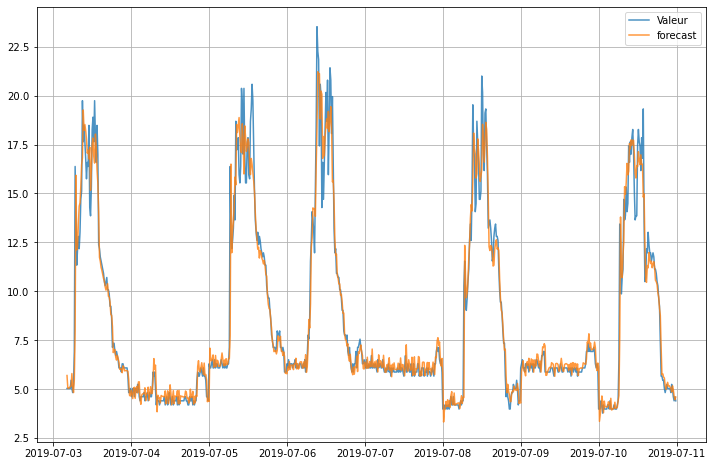

In [44]:
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc[:'2019-07-10'],label=dtype,alpha=0.8)
    #plt.plot('Datetime',dtype,data=fc[:'2019-02-01'],label=dtype,alpha=0.8)
plt.legend()
plt.grid()
plt.rcParams.update({'figure.figsize': (30,20)})
plt.show()

In [46]:
#need to MAPE, RMSE and R-correlation factor
expected = fc.loc[:'2019-07-10','Valeur']
predictions = fc.loc[:'2019-07-10','forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f [kWh]' % rmse)

RMSE: 1.074638 [kWh]


In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)
    np.isfinite(expected).any()
    np.isfinite(predictions).any()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(np.array(expected), np.array(predictions))
print('MAPE: %f %%' % mape)

MAPE: 6.551665 %


In [55]:
fc.head()

,index,Valeur,working day,Radiation (Wh/m²),Temperatures (°C),Wind speed (m/s),forecast,Datetime
Datetime,,,,,,,,
2019-07-03 04:15:00,178357,5.04,True,2.215555,12.344141,1.070780,5.702221,2019-07-03 04:15:00
2019-07-03 04:30:00,178358,5.04,True,2.215555,12.344141,1.070780,5.059544,2019-07-03 04:30:00
2019-07-03 04:45:00,178359,5.04,True,2.215555,12.344141,1.070780,5.051768,2019-07-03 04:45:00
2019-07-03 05:00:00,178360,5.04,True,60.432220,12.798914,1.084056,5.084889,2019-07-03 05:00:00
2019-07-03 05:15:00,178361,5.04,True,60.432220,12.798914,1.084056,5.127402,2019-07-03 05:15:00


In [79]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)
    np.isfinite(expected).any()
    np.isfinite(predictions).any()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = []
for i in range(1,13):
    expected = fc['Valeur'].loc[fc.index.month == i]
    predictions = fc['forecast'].loc[fc.index.month == i]
    mape.append(mean_absolute_percentage_error(np.array(expected), np.array(predictions)))
data_tuples = list(zip(list(range(1,13)), mape))
months = pd.DataFrame(data_tuples, columns=['month','MAPE'])

[Text(0, 0.5, 'MAPE %')]

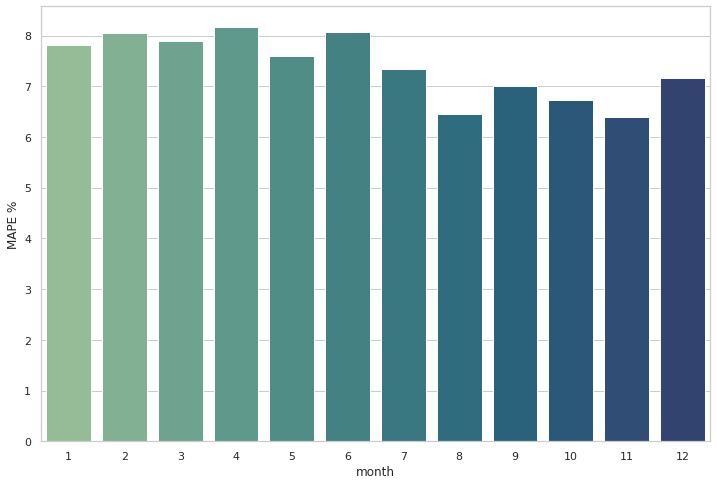

In [149]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
#sns.color_palette('rocket', as_cmap=True)
ax = sns.barplot(x='month', y='MAPE', data = months, palette='crest')
ax.set(ylabel='MAPE %')